# Part 1：Convolutional Neural Networks: Step by Step

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

# 1.1 - Zero-Padding

In [2]:
# GRADED FUNCTION: zero_pad

def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.

    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images    m为样本个数
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions

    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """

    ### START CODE HERE ### (≈ 1 line)
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant')
    ### END CODE HERE ###

    return X_pad

('x.shape =', (4, 3, 3, 2))
('x_pad.shape =', (4, 7, 7, 2))
('x[1,1] =', array([[ 0.90085595, -0.68372786],
       [-0.12289023, -0.93576943],
       [-0.26788808,  0.53035547]]))
('x_pad[1,1] =', array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]))


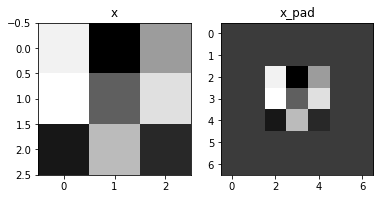

In [3]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

# 1.2 - Single step of convolution

In [4]:
# GRADED FUNCTION: conv_single_step

def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.

    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)

    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    ### START CODE HERE ### (≈ 2 lines of code)
    # Element-wise product between a_slice and W. Do not add the bias yet.
    s = a_slice_prev * W
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = Z + b
    ### END CODE HERE ###

    return Z

In [5]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)


('Z =', array([[[-6.99908945]]]))


# 1.3 - Convolutional Neural Networks - Forward pass

In [6]:
# GRADED FUNCTION: conv_forward

def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function

    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"

    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """

    ### START CODE HERE ###
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape

    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    pad = hparameters["pad"]

    # Compute the dimensions of the CONV output volume using the formula given above. Hint: use int() to floor. (≈2 lines)
    n_H = int((n_H_prev - f + 2*pad) / stride + 1)
    n_W = int((n_W_prev - f + 2*pad) / stride + 1)

    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m, n_H, n_W, n_C))

    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)

    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i, :, :, :]                               # Select ith training example's padded activation
        for h in range(n_H):                           # loop over vertical axis of the output volume
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume

                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = stride * h
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f

                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:, :, :, c], b[:, :, :, c])

    ### END CODE HERE ###

    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))

    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)

    return Z, cache

In [7]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))  # 均值
print("Z[3,2,1] =", Z[3,2,1])
print(Z.shape)
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

("Z's mean =", 0.048995203528855794)
('Z[3,2,1] =', array([-0.61490741, -6.7439236 , -2.55153897,  1.75698377,  3.56208902,
        0.53036437,  5.18531798,  8.75898442]))
(10, 4, 4, 8)
('cache_conv[0][1][2][3] =', array([-0.20075807,  0.18656139,  0.41005165]))


# 1.4 - Pooling layer

In [8]:
def pool_forward(A_prev,hparameters,mode="max"):
    """
    实现池化层的前向传播

    参数：
        A_prev - 输入数据，维度为(m, n_H_prev, n_W_prev, n_C_prev)
        hparameters - 包含了 "f" 和 "stride"的超参数字典
        mode - 模式选择【"max" | "average"】

    返回：
        A - 池化层的输出，维度为 (m, n_H, n_W, n_C)
        cache - 存储了一些反向传播需要用到的值，包含了输入和超参数的字典。
    """

    #获取输入数据的基本信息
    (m , n_H_prev , n_W_prev , n_C_prev) = A_prev.shape

    #获取超参数的信息
    f = hparameters["f"]
    stride = hparameters["stride"]

    #计算输出维度
    n_H = int((n_H_prev - f) / stride ) + 1
    n_W = int((n_W_prev - f) / stride ) + 1
    n_C = n_C_prev

    #初始化输出矩阵
    A = np.zeros((m , n_H , n_W , n_C))

    for i in range(m):                              #遍历样本
        for h in range(n_H):                        #在输出的垂直轴上循环
            for w in range(n_W):                    #在输出的水平轴上循环
                for c in range(n_C):                #循环遍历输出的通道
                    #定位当前的切片位置
                    vert_start = h * stride         #竖向，开始的位置
                    vert_end = vert_start + f       #竖向，结束的位置
                    horiz_start = w * stride        #横向，开始的位置
                    horiz_end = horiz_start + f     #横向，结束的位置
                    #定位完毕，开始切割
                    a_slice_prev = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]

                    #对切片进行池化操作
                    if mode == "max":
                        A[ i , h , w , c ] = np.max(a_slice_prev)
                    elif mode == "average":
                        A[ i , h , w , c ] = np.mean(a_slice_prev)

    #池化完毕，校验数据格式
    assert(A.shape == (m , n_H , n_W , n_C))

    #校验完毕，开始存储用于反向传播的值
    cache = (A_prev,hparameters)

    return A,cache

In [9]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
('A =', array([[[[1.74481176, 0.86540763, 1.13376944]]],


       [[[1.13162939, 1.51981682, 2.18557541]]]]))
()
mode = average
('A =', array([[[[ 0.02105773, -0.20328806, -0.40389855]]],


       [[[-0.22154621,  0.51716526,  0.48155844]]]]))


# Part 2：Convolutional Neural Networks: Application

In [10]:
import math
import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

from tf_utils import * 

%matplotlib inline
np.random.seed(1)

In [11]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2
[0 1 2 3 4 5]
[2]
(1, 1080)


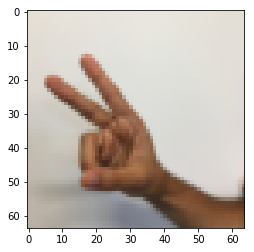

In [12]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))
print(classes)
print(Y_train_orig[:,6])
print(Y_train_orig.shape)

In [13]:
# 数据处理
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [14]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    为session创建占位符

    参数：
        n_H0 - 实数，输入图像的高度
        n_W0 - 实数，输入图像的宽度
        n_C0 - 实数，输入的通道数
        n_y  - 实数，分类数

    输出：
        X - 输入数据的占位符，维度为[None, n_H0, n_W0, n_C0]，类型为"float"
        Y - 输入数据的标签的占位符，维度为[None, n_y]，维度为"float"
    """
    X = tf.placeholder(tf.float32,[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32,[None, n_y])

    return X,Y

In [15]:
X , Y = create_placeholders(64,64,3,6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [16]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """

    tf.set_random_seed(1)                              # so that your "random" numbers match ours

    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2}

    return parameters

In [17]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

    sess_test.close()

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


In [18]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']

    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding='SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
    ### END CODE HERE ###

    return Z3

In [19]:
tf.reset_default_graph()
np.random.seed(1)

with tf.Session() as sess_test:
    X,Y = create_placeholders(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)

    init = tf.global_variables_initializer()
    sess_test.run(init)

    a = sess_test.run(Z3,{X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

    sess_test.close()

Z3 = [[ 1.4416984  -0.24909666  5.450499   -0.2618962  -0.20669907  1.3654671 ]
 [ 1.4070846  -0.02573211  5.08928    -0.48669922 -0.40940708  1.2624859 ]]


In [20]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost

    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    """

    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    ### END CODE HERE ###

    return cost

In [21]:
tf.reset_default_graph()

with tf.Session() as sess_test:
    np.random.seed(1)
    X,Y = create_placeholders(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)

    init = tf.global_variables_initializer()
    sess_test.run(init)
    a = sess_test.run(cost,{X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

    sess_test.close()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = 4.6648693


In [24]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs

    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost

    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###

    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###

    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###

    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    ### END CODE HERE ###

    # Initialize all the variables globally
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:

        # Run the initialization
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###

                minibatch_cost += temp_cost / num_minibatches


            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)


        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.921332
Cost after epoch 5: 1.904156
Cost after epoch 10: 1.904309
Cost after epoch 15: 1.904477
Cost after epoch 20: 1.901876
Cost after epoch 25: 1.784078
Cost after epoch 30: 1.681051
Cost after epoch 35: 1.618206
Cost after epoch 40: 1.597971
Cost after epoch 45: 1.566706
Cost after epoch 50: 1.554487
Cost after epoch 55: 1.502187
Cost after epoch 60: 1.461035
Cost after epoch 65: 1.304490
Cost after epoch 70: 1.201760
Cost after epoch 75: 1.163242
Cost after epoch 80: 1.102885
Cost after epoch 85: 1.087105
Cost after epoch 90: 1.051911
Cost after epoch 95: 1.018554


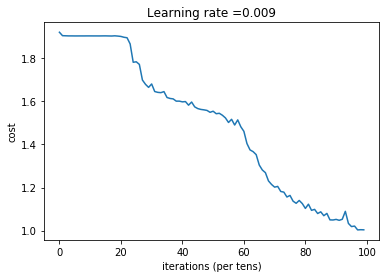

Tensor("Mean_1:0", shape=(), dtype=float32)
('Train Accuracy:', 0.6666667)
('Test Accuracy:', 0.5833333)


In [25]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

In [ ]:
permutation = list(np.random.permutation(64))
Y_train.reshape((64,6))
print(Y_train.shape)
shuffled_Y=Y_train[permutation,:]
print(shuffled_Y.shape)

In [ ]:
print(X.shape)